In [ ]:
# function ConnectButton(){
#   console.log("Connect pushed");
#   document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
# }
# setInterval(ConnectButton, 600000);

In [1]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
import zipfile
import subprocess
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchsummary
import numpy as np
from PIL import Image
from PIL import ImageFile
import json
import cv2
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import random

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
def seed_everything(seed=42):
    """
    모든 랜덤 시드를 주어진 값으로 고정합니다.
    """
    random.seed(seed)  # Python random 모듈
    np.random.seed(seed)  # Numpy 랜덤 시드
    torch.manual_seed(seed)  # PyTorch 랜덤 시드

    torch.cuda.manual_seed(seed)  # GPU를 위한 PyTorch 랜덤 시드
    torch.cuda.manual_seed_all(seed)  # 멀티 GPU를 위한 PyTorch 랜덤 시드

seed_everything()

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_zip_paths, label_zip_paths, cache_dir, transform=None, workers=4):
        super().__init__()
        self.image_zip_paths = image_zip_paths
        self.label_zip_paths = label_zip_paths
        self.cache_dir = cache_dir
        self.transform = transform
        self.workers = workers

        if not os.path.exists(self.cache_dir):
            os.makedirs(self.cache_dir, exist_ok=True)

        self.image_names = {}
        self.label_names = {}
        self.image_list = []

        self._prepare()

    def _extract_and_cache(self, zip_path, file_name, cache_file_path, attempts=3):
        if os.path.exists(cache_file_path):
            return True

        command = ["unzip", "-o", zip_path, file_name, "-d", os.path.dirname(cache_file_path)]

        for attempt in range(attempts):
            result = subprocess.run(command, check=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            # 성공적으로 압축 해제되었거나, 경고만 있는 경우
            if result.returncode == 0 or "warning" in result.stderr.decode().lower():
                return True
            else:
                # 오류 메시지가 있고, 재시도 횟수가 남아있는 경우
                print(f"Attempt {attempt + 1}: Error unzipping file => {zip_path}")
                time.sleep(2 ** attempt)

        # 모든 시도가 실패한 경우
        print(f"Failed to extract {file_name}")
        return False

    def _prepare(self):
        max_tries = 3
        wait_seconds = 10

        # 각 zip 파일에 대한 재시도 횟수를 추적
        retries = {zip_path: 0 for zip_path in self.image_zip_paths + self.label_zip_paths}

        # 전체 압축 파일 리스트
        to_process = [(zip_path, '.png') for zip_path in self.image_zip_paths] + [(zip_path, '.json') for zip_path in self.label_zip_paths]

        while to_process:
            # 병렬처리
            with ThreadPoolExecutor(max_workers=self.workers) as executor:
                future_to_zip_path = {
                    executor.submit(self._process_zip, zip_path, file_extension): (zip_path, file_extension)
                    for zip_path, file_extension in to_process
                }

                # 처리 중 예외 발생 시 재시도할 작업 목록
                to_retry = []

                # future 객체의 작업완료 상황을 모니터링
                for future in as_completed(future_to_zip_path):
                    zip_path, file_extension = future_to_zip_path[future]

                    try:
                        success = future.result()
                        if not success:
                            raise Exception(f"Failed to process {zip_path}")

                    except OSError as e: # 구글드라이브와의 연결로 인한 예외처리
                        if e.errno == 107 and retries[zip_path] < max_tries:
                            print(f"OSError [Errno 107] => {zip_path}")
                            to_retry.append((zip_path, file_extension))
                            retries[zip_path] += 1
                            time.sleep(wait_seconds)  # 각 재시도 사이에 대기
                            wait_seconds *= 2  # 대기 시간 증가
                        else:
                            print(f"Unexpected Error : {zip_path}: {e}")

                    except Exception as e:
                        print(f"Exception processing {zip_path}: {e}")

                # 재시도할 작업이 있으면 to_process 업데이트
                to_process = to_retry if to_retry else []

        self.image_list = sorted(self.image_names.keys())

    def _process_zip(self, zip_path, file_extension):
        success = True
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:

            for file_name in sorted(zip_ref.namelist()):

                if file_name.endswith(file_extension):
                    base_name = os.path.splitext(os.path.basename(file_name))[0].lstrip('_')  # 확장자 제외 파일 기본 이름

                    # 데이터 접근시 사용할 경로
                    cache_file_path = os.path.join(self.cache_dir, os.path.basename(zip_path).replace('.zip', ''), file_name.replace('/', '_').lstrip('_'))

                    if file_extension == '.png':
                        self.image_names[base_name.lower()] = cache_file_path
                    else:
                        self.label_names[base_name.lower()] = cache_file_path

                    extract_success = self._extract_and_cache(zip_path, file_name, cache_file_path)
                    success = success and extract_success

        return success

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # 파일 이름을 키 리스트에서 추출
        base_name = self.image_list[idx]

        image_path = self.image_names.get(base_name)

        try:
            image = Image.open(image_path)
        except Exception as e:
            return None

        label_path = self.label_names.get(base_name)
        with open(label_path, 'r') as f:
            label_data = json.load(f)

        age_past = label_data['age_past']
        gender = label_data['gender']
        box = label_data['annotation'][0]['box']

        image = image.crop((box['x'], box['y'], box['x'] + box['w'], box['y'] + box['h']))

        if self.transform:
            image = self.transform(image)

        gender_label = 0 if gender == 'male' else 1

        label = {'age_past': age_past, 'gender': gender_label}

        return image, label


In [5]:
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.6284, 0.4901, 0.4325), (0.1869, 0.1712, 0.1561))
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.6284, 0.4901, 0.4325), (0.1869, 0.1712, 0.1561))
])

In [6]:
def get_zip_files(directory):
    return [os.path.join(directory, zip) for zip in os.listdir(directory) if zip.endswith('.zip')] # 리스트를 정렬하면 속도 하락

train_images = '/content/drive/MyDrive/DL_Project/data/Training/image'
train_labels = '/content/drive/MyDrive/DL_Project/data/Training/label'
train_cache = '/content/cache/train'

val_images = '/content/drive/MyDrive/DL_Project/data/Validation/image'
val_labels = '/content/drive/MyDrive/DL_Project/data/Validation/label'
val_cache = '/content/cache/val'

train_image_zips = get_zip_files(train_images)
train_label_zips = get_zip_files(train_labels)
val_image_zips = get_zip_files(val_images)
val_label_zips = get_zip_files(val_labels)

In [7]:
train_image_zips[:3]

['/content/drive/MyDrive/DL_Project/data/Training/image/TS_0805.zip',
 '/content/drive/MyDrive/DL_Project/data/Training/image/TS_0631.zip',
 '/content/drive/MyDrive/DL_Project/data/Training/image/TS_0576.zip']

In [8]:
len(train_image_zips)

803

In [ ]:
%time train_dataset = CustomDataset(train_image_zips, train_label_zips, train_cache, transform_train)

In [ ]:
len(train_dataset)

40150

In [ ]:
%time val_dataset = CustomDataset(val_image_zips, val_label_zips, val_cache, transform_val)

CPU times: user 4.87 s, sys: 2.52 s, total: 7.39 s
Wall time: 2min 27s


In [ ]:
def custom_collate_fn(batch):
    batch = [item for item in batch if item is not None]
    return torch.utils.data.dataloader.default_collate(batch)

In [ ]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    collate_fn=custom_collate_fn,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    prefetch_factor=4
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    collate_fn=custom_collate_fn,
    batch_size=batch_size,
    num_workers=2,
    prefetch_factor=4
)

In [ ]:
x, y = next(iter(train_loader))
x.shape

torch.Size([64, 3, 224, 224])

In [ ]:
y['age_past'].shape, y['gender'].shape

(torch.Size([64]), torch.Size([64]))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class Gender_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        # average pooling
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(x)
        x = x.squeeze()
        return x

In [ ]:
gender_model = Gender_Net().to(device)
torchsummary.summary(gender_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
       BatchNorm2d-2         [-1, 32, 222, 222]              64
         MaxPool2d-3         [-1, 32, 110, 110]               0
            Conv2d-4         [-1, 64, 108, 108]          18,496
       BatchNorm2d-5         [-1, 64, 108, 108]             128
         MaxPool2d-6           [-1, 64, 53, 53]               0
            Conv2d-7          [-1, 128, 51, 51]          73,856
       BatchNorm2d-8          [-1, 128, 51, 51]             256
         MaxPool2d-9          [-1, 128, 25, 25]               0
           Conv2d-10          [-1, 256, 23, 23]         295,168
      BatchNorm2d-11          [-1, 256, 23, 23]             512
        MaxPool2d-12          [-1, 256, 11, 11]               0
           Conv2d-13            [-1, 512, 9, 9]       1,180,160
      BatchNorm2d-14            [-1, 51

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

opt_gender = optim.Adam(gender_model.parameters(), lr=0.0003)
gender_lr_scheduler = ReduceLROnPlateau(opt_gender, mode='min', verbose=True)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_loss = np.inf
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping")

In [ ]:
early_stopping = EarlyStopping(patience=5, verbose=True)

In [ ]:
def save_model(epoch, model, optimizer, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

In [ ]:
# 모델 이어서 학습
def load_model(model, optimizer, path):
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch

In [ ]:
def train_loop_gender(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    size = len(dataloader.dataset)
    total_loss = 0.0
    correct = 0  # 맞춘 개수 초기화
    total = 0     # 전체 개수 초기화
    start_time = time.time()  # 에포크 시작 시간

    for batch, (x, y) in enumerate(dataloader):
        batch_start_time = time.time()  # 배치 처리 시작 시간
        x, y = x.to(device), y['gender'].float().to(device)
        pred = model(x)
        loss = loss_fn(pred.squeeze(), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # 정확도 계산
        pred = torch.sigmoid(pred)
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        total += y.size(0)
        correct += torch.sum(pred == y).item()

        batch_process_time = time.time() - batch_start_time

        if batch % 10 == 0:
            processed = (batch + 1) * len(x)
            print(f'Epoch {epoch+1} : [{processed} / {size}] loss : {loss.item()}, Batch time: {batch_process_time:.4f} sec')

    accuracy = 100 * correct / total  # 정확도 계산
    average_loss = total_loss / len(dataloader)
    epoch_time = time.time() - start_time

    print(f"Epoch {epoch+1} finished, Total Epoch time: {epoch_time:.4f} sec")
    return average_loss, accuracy

In [ ]:
def validation_loop_gender(dataloader, model, loss_fn, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y['gender'].float().to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            val_loss += loss.item()

            # 정확도 계산
            pred = torch.sigmoid(pred)
            pred[pred >= 0.5] = 1
            pred[pred < 0.5] = 0
            total += y.size(0)
            correct += torch.sum(pred == y).item()

    accuracy = 100 * correct / total
    val_loss /= len(dataloader)
    return val_loss, accuracy

In [ ]:
# 모델 훈련 시작
start = time.time()
for epoch in range(30):
    gender_loss, gender_accuracy = train_loop_gender(train_loader, gender_model, nn.BCEWithLogitsLoss(), opt_gender, epoch)
    val_loss, val_accuracy = validation_loop_gender(val_loader, gender_model, nn.BCEWithLogitsLoss(), device)
    gender_lr_scheduler.step(val_loss)
    early_stopping(val_loss)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        save_model(epoch, gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v3_checkpoint.pth')
        break

    save_model(epoch, gender_model, opt_gender, f'/content/drive/MyDrive/models/gender_model_v3_checkpoint_epoch_{epoch+1}.pth')
    print(f'Epoch : {epoch+1}, Loss : {gender_loss}, Val_loss : {val_loss}, Accuracy: {gender_accuracy:.2f}%, Val_accuracy: {val_accuracy:.2f}%')

total_time = time.time() - start
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 1 : [64 / 40150] loss : 0.6912270784378052, Batch time: 0.1975 sec
Epoch 1 : [704 / 40150] loss : 0.6657211780548096, Batch time: 0.1980 sec
Epoch 1 : [1344 / 40150] loss : 0.670681357383728, Batch time: 0.1871 sec
Epoch 1 : [1984 / 40150] loss : 0.5910769104957581, Batch time: 0.1901 sec
Epoch 1 : [2624 / 40150] loss : 0.5087184906005859, Batch time: 0.1947 sec
Epoch 1 : [3264 / 40150] loss : 0.6365774273872375, Batch time: 0.1947 sec
Epoch 1 : [3904 / 40150] loss : 0.5657888650894165, Batch time: 0.1535 sec
Epoch 1 : [4544 / 40150] loss : 0.5166085958480835, Batch time: 0.1531 sec
Epoch 1 : [5184 / 40150] loss : 0.5912333130836487, Batch time: 0.1592 sec
Epoch 1 : [5824 / 40150] loss : 0.5485919713973999, Batch time: 0.1525 sec
Epoch 1 : [6464 / 40150] loss : 0.5803212523460388, Batch time: 0.1649 sec
Epoch 1 : [7104 / 40150] loss : 0.6030408143997192, Batch time: 0.1873 sec
Epoch 1 : [7744 / 40150] loss : 0.7148694396018982, Batch time: 0.1985 sec
Epoch 1 : [8384 / 40150] loss

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 : [12864 / 40150] loss : 0.6144801378250122, Batch time: 0.1987 sec
Epoch 1 : [13504 / 40150] loss : 0.5526773929595947, Batch time: 0.1976 sec
Epoch 1 : [14144 / 40150] loss : 0.6789820194244385, Batch time: 0.1953 sec
Epoch 1 : [14784 / 40150] loss : 0.5121597051620483, Batch time: 0.1972 sec
Epoch 1 : [15424 / 40150] loss : 0.5410413146018982, Batch time: 0.1890 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1 : [16064 / 40150] loss : 0.48799437284469604, Batch time: 0.1972 sec
Epoch 1 : [16704 / 40150] loss : 0.4442363381385803, Batch time: 0.1985 sec
Epoch 1 : [17344 / 40150] loss : 0.5192734599113464, Batch time: 0.1880 sec
Epoch 1 : [17984 / 40150] loss : 0.4393399655818939, Batch time: 0.1988 sec
Epoch 1 : [18624 / 40150] loss : 0.544863760471344, Batch time: 0.1946 sec
Epoch 1 : [19264 / 40150] loss : 0.5088679790496826, Batch time: 0.1986 sec
Epoch 1 : [19904 / 40150] loss : 0.42670565843582153, Batch time: 0.1981 sec
Epoch 1 : [20544 / 40150] loss : 0.4597722589969635, Batch time: 0.1943 sec
Epoch 1 : [21184 / 40150] loss : 0.7094275951385498, Batch time: 0.1875 sec
Epoch 1 : [21824 / 40150] loss : 0.5727799534797668, Batch time: 0.1986 sec
Epoch 1 : [22464 / 40150] loss : 0.4992283582687378, Batch time: 0.1992 sec
Epoch 1 : [23104 / 40150] loss : 0.5242053270339966, Batch time: 0.1942 sec
Epoch 1 : [23744 / 40150] loss : 0.4707677960395813, Batch time: 0.1975 sec
Epoch 1 : [

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 : [5184 / 40150] loss : 0.31186020374298096, Batch time: 0.1922 sec
Epoch 2 : [5824 / 40150] loss : 0.39196115732192993, Batch time: 0.1987 sec
Epoch 2 : [6464 / 40150] loss : 0.2913483679294586, Batch time: 0.1898 sec
Epoch 2 : [7104 / 40150] loss : 0.4493314325809479, Batch time: 0.1984 sec
Epoch 2 : [7744 / 40150] loss : 0.41788339614868164, Batch time: 0.1986 sec
Epoch 2 : [8384 / 40150] loss : 0.2520381808280945, Batch time: 0.1870 sec
Epoch 2 : [9024 / 40150] loss : 0.37775230407714844, Batch time: 0.1972 sec
Epoch 2 : [9664 / 40150] loss : 0.31726574897766113, Batch time: 0.1987 sec
Epoch 2 : [10304 / 40150] loss : 0.4216308891773224, Batch time: 0.1989 sec
Epoch 2 : [10944 / 40150] loss : 0.2922966778278351, Batch time: 0.1945 sec
Epoch 2 : [11584 / 40150] loss : 0.43171262741088867, Batch time: 0.1915 sec
Epoch 2 : [12224 / 40150] loss : 0.5379894971847534, Batch time: 0.1986 sec
Epoch 2 : [12864 / 40150] loss : 0.35414135456085205, Batch time: 0.1989 sec
Epoch 2 : [13

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2 : [33984 / 40150] loss : 0.4237387478351593, Batch time: 0.1961 sec
Epoch 2 : [34624 / 40150] loss : 0.44816261529922485, Batch time: 0.1915 sec
Epoch 2 : [35264 / 40150] loss : 0.39490941166877747, Batch time: 0.1890 sec
Epoch 2 : [35904 / 40150] loss : 0.2856650650501251, Batch time: 0.2007 sec
Epoch 2 : [36544 / 40150] loss : 0.3184734284877777, Batch time: 0.1946 sec
Epoch 2 : [37184 / 40150] loss : 0.35295194387435913, Batch time: 0.1888 sec
Epoch 2 : [37824 / 40150] loss : 0.3988833427429199, Batch time: 0.1901 sec
Epoch 2 : [38464 / 40150] loss : 0.3400925397872925, Batch time: 0.1955 sec
Epoch 2 : [39104 / 40150] loss : 0.41504591703414917, Batch time: 0.1910 sec
Epoch 2 : [39744 / 40150] loss : 0.3816242218017578, Batch time: 0.1897 sec
Epoch 2 finished, Total Epoch time: 1647.7888 sec
Epoch : 2, Loss : 0.3934458722449412, Val_loss : 0.33174831476769867, Accuracy: 81.42%, Val_accuracy: 84.44%
Epoch 3 : [64 / 40150] loss : 0.39464235305786133, Batch time: 0.1977 sec
Epo

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 : [34624 / 40150] loss : 0.3717488646507263, Batch time: 0.1997 sec
Epoch 3 : [35264 / 40150] loss : 0.44551724195480347, Batch time: 0.1983 sec
Epoch 3 : [35904 / 40150] loss : 0.44978228211402893, Batch time: 0.1869 sec
Epoch 3 : [36544 / 40150] loss : 0.3695821166038513, Batch time: 0.2001 sec
Epoch 3 : [37184 / 40150] loss : 0.3464750051498413, Batch time: 0.2003 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3 : [37824 / 40150] loss : 0.26593726873397827, Batch time: 0.1989 sec
Epoch 3 : [38464 / 40150] loss : 0.33812689781188965, Batch time: 0.1895 sec
Epoch 3 : [39104 / 40150] loss : 0.365084707736969, Batch time: 0.1995 sec
Epoch 3 : [39744 / 40150] loss : 0.3250691890716553, Batch time: 0.1929 sec
Epoch 3 finished, Total Epoch time: 1600.4067 sec
Epoch : 3, Loss : 0.3572043363645578, Val_loss : 0.2973895805734622, Accuracy: 83.33%, Val_accuracy: 86.32%
Epoch 4 : [64 / 40150] loss : 0.2557602822780609, Batch time: 0.1985 sec
Epoch 4 : [704 / 40150] loss : 0.25999605655670166, Batch time: 0.1988 sec
Epoch 4 : [1344 / 40150] loss : 0.3996902108192444, Batch time: 0.1988 sec
Epoch 4 : [1984 / 40150] loss : 0.3388719856739044, Batch time: 0.1937 sec
Epoch 4 : [2624 / 40150] loss : 0.2724050283432007, Batch time: 0.1991 sec
Epoch 4 : [3264 / 40150] loss : 0.27355462312698364, Batch time: 0.1912 sec
Epoch 4 : [3904 / 40150] loss : 0.323588490486145, Batch time: 0.1698 sec
Epoch 4 : [454

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 : [9024 / 40150] loss : 0.3499096930027008, Batch time: 0.1906 sec
Epoch 4 : [9664 / 40150] loss : 0.36954089999198914, Batch time: 0.1876 sec
Epoch 4 : [10304 / 40150] loss : 0.32952672243118286, Batch time: 0.1985 sec
Epoch 4 : [10944 / 40150] loss : 0.3362920880317688, Batch time: 0.1988 sec
Epoch 4 : [11584 / 40150] loss : 0.24069488048553467, Batch time: 0.1864 sec
Epoch 4 : [12224 / 40150] loss : 0.4308241009712219, Batch time: 0.1992 sec
Epoch 4 : [12864 / 40150] loss : 0.47773516178131104, Batch time: 0.1872 sec
Epoch 4 : [13504 / 40150] loss : 0.38022130727767944, Batch time: 0.1888 sec
Epoch 4 : [14144 / 40150] loss : 0.26151907444000244, Batch time: 0.1986 sec
Epoch 4 : [14784 / 40150] loss : 0.3207094669342041, Batch time: 0.1891 sec
Epoch 4 : [15424 / 40150] loss : 0.32289546728134155, Batch time: 0.1990 sec
Epoch 4 : [16064 / 40150] loss : 0.491377055644989, Batch time: 0.1992 sec
Epoch 4 : [16704 / 40150] loss : 0.2892114520072937, Batch time: 0.1988 sec
Epoch 4 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4 : [17984 / 40150] loss : 0.43383294343948364, Batch time: 0.1990 sec
Epoch 4 : [18624 / 40150] loss : 0.22902622818946838, Batch time: 0.1987 sec
Epoch 4 : [19264 / 40150] loss : 0.3279467821121216, Batch time: 0.1943 sec
Epoch 4 : [19904 / 40150] loss : 0.31220147013664246, Batch time: 0.1900 sec
Epoch 4 : [20544 / 40150] loss : 0.3335198760032654, Batch time: 0.1960 sec
Epoch 4 : [21184 / 40150] loss : 0.387922078371048, Batch time: 0.1992 sec
Epoch 4 : [21824 / 40150] loss : 0.35986804962158203, Batch time: 0.1890 sec
Epoch 4 : [22464 / 40150] loss : 0.21332049369812012, Batch time: 0.1992 sec
Epoch 4 : [23104 / 40150] loss : 0.40942880511283875, Batch time: 0.1921 sec
Epoch 4 : [23744 / 40150] loss : 0.27142322063446045, Batch time: 0.1988 sec
Epoch 4 : [24384 / 40150] loss : 0.3313640356063843, Batch time: 0.1989 sec
Epoch 4 : [25024 / 40150] loss : 0.33598965406417847, Batch time: 0.1875 sec
Epoch 4 : [25664 / 40150] loss : 0.3671545088291168, Batch time: 0.1992 sec
Epoch

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 : [7744 / 40150] loss : 0.4132792353630066, Batch time: 0.1988 sec
Epoch 5 : [8384 / 40150] loss : 0.32800790667533875, Batch time: 0.1878 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5 : [9024 / 40150] loss : 0.3075830340385437, Batch time: 0.1929 sec
Epoch 5 : [9664 / 40150] loss : 0.36674416065216064, Batch time: 0.1870 sec
Epoch 5 : [10304 / 40150] loss : 0.25355011224746704, Batch time: 0.1918 sec
Epoch 5 : [10944 / 40150] loss : 0.3149399161338806, Batch time: 0.1987 sec
Epoch 5 : [11584 / 40150] loss : 0.2714376747608185, Batch time: 0.1990 sec
Epoch 5 : [12224 / 40150] loss : 0.4730404019355774, Batch time: 0.1991 sec
Epoch 5 : [12864 / 40150] loss : 0.26456519961357117, Batch time: 0.2013 sec
Epoch 5 : [13504 / 40150] loss : 0.2842060923576355, Batch time: 0.2015 sec
Epoch 5 : [14144 / 40150] loss : 0.2663109302520752, Batch time: 0.1946 sec
Epoch 5 : [14784 / 40150] loss : 0.23610994219779968, Batch time: 0.1993 sec
Epoch 5 : [15424 / 40150] loss : 0.23386433720588684, Batch time: 0.1983 sec
Epoch 5 : [16064 / 40150] loss : 0.41380298137664795, Batch time: 0.2003 sec
Epoch 5 : [16704 / 40150] loss : 0.3183400630950928, Batch time: 0.1989 sec
Epoch 5 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 : [7104 / 40150] loss : 0.22584976255893707, Batch time: 0.1656 sec
Epoch 6 : [7744 / 40150] loss : 0.30413755774497986, Batch time: 0.1622 sec
Epoch 6 : [8384 / 40150] loss : 0.39009010791778564, Batch time: 0.1654 sec
Epoch 6 : [9024 / 40150] loss : 0.23247212171554565, Batch time: 0.1680 sec
Epoch 6 : [9664 / 40150] loss : 0.31906425952911377, Batch time: 0.1644 sec
Epoch 6 : [10304 / 40150] loss : 0.3101961016654968, Batch time: 0.1544 sec
Epoch 6 : [10944 / 40150] loss : 0.25517454743385315, Batch time: 0.1998 sec
Epoch 6 : [11584 / 40150] loss : 0.33777350187301636, Batch time: 0.1881 sec
Epoch 6 : [12224 / 40150] loss : 0.2985871434211731, Batch time: 0.1966 sec
Epoch 6 : [12864 / 40150] loss : 0.32973140478134155, Batch time: 0.1985 sec
Epoch 6 : [13504 / 40150] loss : 0.41868120431900024, Batch time: 0.1989 sec
Epoch 6 : [14144 / 40150] loss : 0.26875069737434387, Batch time: 0.1986 sec
Epoch 6 : [14784 / 40150] loss : 0.2688620686531067, Batch time: 0.1878 sec
Epoch 6

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6 : [29504 / 40150] loss : 0.3423802852630615, Batch time: 0.1868 sec
Epoch 6 : [30144 / 40150] loss : 0.21530427038669586, Batch time: 0.1951 sec
Epoch 6 : [30784 / 40150] loss : 0.2901005744934082, Batch time: 0.1896 sec
Epoch 6 : [31424 / 40150] loss : 0.18018166720867157, Batch time: 0.1978 sec
Epoch 6 : [32064 / 40150] loss : 0.43762725591659546, Batch time: 0.2004 sec
Epoch 6 : [32704 / 40150] loss : 0.29983124136924744, Batch time: 0.1877 sec
Epoch 6 : [33344 / 40150] loss : 0.31267955899238586, Batch time: 0.1995 sec
Epoch 6 : [33984 / 40150] loss : 0.3225614130496979, Batch time: 0.1951 sec
Epoch 6 : [34624 / 40150] loss : 0.31197434663772583, Batch time: 0.2003 sec
Epoch 6 : [35264 / 40150] loss : 0.2508940100669861, Batch time: 0.1985 sec
Epoch 6 : [35904 / 40150] loss : 0.24646048247814178, Batch time: 0.2001 sec
Epoch 6 : [36544 / 40150] loss : 0.31897422671318054, Batch time: 0.1996 sec
Epoch 6 : [37184 / 40150] loss : 0.4854784309864044, Batch time: 0.1890 sec
Epoc

KeyboardInterrupt: 

In [ ]:
# 모델과 옵티마이저 초기화
gender_model = Gender_Net().to(device)
opt_gender = optim.Adam(gender_model.parameters(), lr=0.0003)

# 체크포인트 불러오기
gender_model, opt_gender, start_epoch = load_model(gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v3_checkpoint_epoch_13.pth')

# 학습 재개
start = time.time()
for epoch in range(start_epoch + 1, start_epoch + 28):
    gender_loss, gender_accuracy = train_loop_gender(train_loader, gender_model, nn.BCEWithLogitsLoss(), opt_gender, epoch)
    val_loss, val_accuracy = validation_loop_gender(val_loader, gender_model, nn.BCEWithLogitsLoss(), device)
    gender_lr_scheduler.step(val_loss)
    early_stopping(val_loss)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        save_model(epoch, gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v3_checkpoint.pth')
        break

    save_model(epoch, gender_model, opt_gender, f'/content/drive/MyDrive/models/gender_model_v3_checkpoint_epoch_{epoch+1}.pth')
    print(f'Epoch : {epoch+1}, Loss : {gender_loss}, Val_loss : {val_loss}, Accuracy: {gender_accuracy:.2f}%, Val_accuracy: {val_accuracy:.2f}%')

total_time = time.time() - start
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 14 : [64 / 40150] loss : 0.2367580384016037, Batch time: 0.8332 sec
Epoch 14 : [704 / 40150] loss : 0.2362922877073288, Batch time: 0.1983 sec
Epoch 14 : [1344 / 40150] loss : 0.3855285346508026, Batch time: 0.1994 sec
Epoch 14 : [1984 / 40150] loss : 0.23075997829437256, Batch time: 0.1978 sec
Epoch 14 : [2624 / 40150] loss : 0.21813200414180756, Batch time: 0.1980 sec
Epoch 14 : [3264 / 40150] loss : 0.29007357358932495, Batch time: 0.1525 sec
Epoch 14 : [3904 / 40150] loss : 0.26243311166763306, Batch time: 0.1982 sec
Epoch 14 : [4544 / 40150] loss : 0.3029531240463257, Batch time: 0.1995 sec
Epoch 14 : [5184 / 40150] loss : 0.19406282901763916, Batch time: 0.1980 sec
Epoch 14 : [5824 / 40150] loss : 0.19980692863464355, Batch time: 0.1537 sec
Epoch 14 : [6464 / 40150] loss : 0.1518789529800415, Batch time: 0.1530 sec
Epoch 14 : [7104 / 40150] loss : 0.15106803178787231, Batch time: 0.1598 sec
Epoch 14 : [7744 / 40150] loss : 0.2040528506040573, Batch time: 0.1648 sec
Epoch 14

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 : [21184 / 40150] loss : 0.1960417628288269, Batch time: 0.1992 sec
Epoch 14 : [21824 / 40150] loss : 0.21166115999221802, Batch time: 0.1979 sec
Epoch 14 : [22464 / 40150] loss : 0.21499547362327576, Batch time: 0.1919 sec
Epoch 14 : [23104 / 40150] loss : 0.2495030164718628, Batch time: 0.1980 sec
Epoch 14 : [23744 / 40150] loss : 0.20088648796081543, Batch time: 0.1991 sec
Epoch 14 : [24384 / 40150] loss : 0.11035390198230743, Batch time: 0.1981 sec
Epoch 14 : [25024 / 40150] loss : 0.2694717049598694, Batch time: 0.1982 sec
Epoch 14 : [25664 / 40150] loss : 0.3705199360847473, Batch time: 0.1963 sec
Epoch 14 : [26304 / 40150] loss : 0.22974303364753723, Batch time: 0.1990 sec
Epoch 14 : [26944 / 40150] loss : 0.210378497838974, Batch time: 0.1982 sec
Epoch 14 : [27584 / 40150] loss : 0.2502863109111786, Batch time: 0.1978 sec
Epoch 14 : [28224 / 40150] loss : 0.3314403295516968, Batch time: 0.1982 sec
Epoch 14 : [28864 / 40150] loss : 0.13449838757514954, Batch time: 0.192

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14 : [33344 / 40150] loss : 0.1938287317752838, Batch time: 0.1883 sec
Epoch 14 : [33984 / 40150] loss : 0.15074369311332703, Batch time: 0.1980 sec
Epoch 14 : [34624 / 40150] loss : 0.09996676445007324, Batch time: 0.1867 sec
Epoch 14 : [35264 / 40150] loss : 0.2407515048980713, Batch time: 0.1983 sec
Epoch 14 : [35904 / 40150] loss : 0.22160246968269348, Batch time: 0.1979 sec
Epoch 14 : [36544 / 40150] loss : 0.2113582342863083, Batch time: 0.1983 sec
Epoch 14 : [37184 / 40150] loss : 0.19477993249893188, Batch time: 0.1893 sec
Epoch 14 : [37824 / 40150] loss : 0.2141512930393219, Batch time: 0.1988 sec
Epoch 14 : [38464 / 40150] loss : 0.23360037803649902, Batch time: 0.1929 sec
Epoch 14 : [39104 / 40150] loss : 0.2755100429058075, Batch time: 0.1865 sec
Epoch 14 : [39744 / 40150] loss : 0.126529723405838, Batch time: 0.1995 sec
Epoch 14 finished, Total Epoch time: 1593.0278 sec
Epoch : 14, Loss : 0.2280779519610724, Val_loss : 0.24741079691278783, Accuracy: 90.10%, Val_accur

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 : [25664 / 40150] loss : 0.24024119973182678, Batch time: 0.1978 sec
Epoch 15 : [26304 / 40150] loss : 0.18520411849021912, Batch time: 0.1956 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15 : [26944 / 40150] loss : 0.14504921436309814, Batch time: 0.1930 sec
Epoch 15 : [27584 / 40150] loss : 0.28237882256507874, Batch time: 0.1897 sec
Epoch 15 : [28224 / 40150] loss : 0.23865365982055664, Batch time: 0.1938 sec
Epoch 15 : [28864 / 40150] loss : 0.3632434904575348, Batch time: 0.1906 sec
Epoch 15 : [29504 / 40150] loss : 0.20681260526180267, Batch time: 0.1861 sec
Epoch 15 : [30144 / 40150] loss : 0.21895615756511688, Batch time: 0.1921 sec
Epoch 15 : [30784 / 40150] loss : 0.25178903341293335, Batch time: 0.1869 sec
Epoch 15 : [31424 / 40150] loss : 0.1633971482515335, Batch time: 0.1981 sec
Epoch 15 : [32064 / 40150] loss : 0.17611166834831238, Batch time: 0.1984 sec
Epoch 15 : [32704 / 40150] loss : 0.28829503059387207, Batch time: 0.1997 sec
Epoch 15 : [33344 / 40150] loss : 0.2979751229286194, Batch time: 0.1975 sec
Epoch 15 : [33984 / 40150] loss : 0.2051307111978531, Batch time: 0.1873 sec
Epoch 15 : [34624 / 40150] loss : 0.2717440128326416, Batch time: 0.

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 : [10944 / 40150] loss : 0.20965631306171417, Batch time: 0.1687 sec
Epoch 16 : [11584 / 40150] loss : 0.3307446837425232, Batch time: 0.1554 sec
Epoch 16 : [12224 / 40150] loss : 0.16859185695648193, Batch time: 0.1605 sec
Epoch 16 : [12864 / 40150] loss : 0.2834462523460388, Batch time: 0.1652 sec
Epoch 16 : [13504 / 40150] loss : 0.21015891432762146, Batch time: 0.1538 sec
Epoch 16 : [14144 / 40150] loss : 0.24534401297569275, Batch time: 0.1524 sec
Epoch 16 : [14784 / 40150] loss : 0.2414124310016632, Batch time: 0.1696 sec
Epoch 16 : [15424 / 40150] loss : 0.1567862331867218, Batch time: 0.1525 sec
Epoch 16 : [16064 / 40150] loss : 0.1607920229434967, Batch time: 0.1572 sec
Epoch 16 : [16704 / 40150] loss : 0.1073203831911087, Batch time: 0.1676 sec
Epoch 16 : [17344 / 40150] loss : 0.17214547097682953, Batch time: 0.1662 sec
Epoch 16 : [17984 / 40150] loss : 0.29063236713409424, Batch time: 0.1623 sec
Epoch 16 : [18624 / 40150] loss : 0.2226039469242096, Batch time: 0.15

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16 : [34624 / 40150] loss : 0.16286158561706543, Batch time: 0.1539 sec
Epoch 16 : [35264 / 40150] loss : 0.12651586532592773, Batch time: 0.1684 sec
Epoch 16 : [35904 / 40150] loss : 0.2734818458557129, Batch time: 0.1677 sec
Epoch 16 : [36544 / 40150] loss : 0.3691272735595703, Batch time: 0.1542 sec
Epoch 16 : [37184 / 40150] loss : 0.23515060544013977, Batch time: 0.1669 sec
Epoch 16 : [37824 / 40150] loss : 0.1952667534351349, Batch time: 0.1618 sec
Epoch 16 : [38464 / 40150] loss : 0.20922264456748962, Batch time: 0.1535 sec
Epoch 16 : [39104 / 40150] loss : 0.1714847981929779, Batch time: 0.1572 sec
Epoch 16 : [39744 / 40150] loss : 0.2448333203792572, Batch time: 0.1693 sec
Epoch 16 finished, Total Epoch time: 1623.6380 sec
Epoch : 16, Loss : 0.22134018423640803, Val_loss : 0.26034928820555725, Accuracy: 90.60%, Val_accuracy: 88.91%
Epoch 17 : [64 / 40150] loss : 0.24047543108463287, Batch time: 0.1897 sec
Epoch 17 : [704 / 40150] loss : 0.21014727652072906, Batch time: 0

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 : [2624 / 40150] loss : 0.2873644232749939, Batch time: 0.1989 sec
Epoch 17 : [3264 / 40150] loss : 0.3499003052711487, Batch time: 0.1970 sec
Epoch 17 : [3904 / 40150] loss : 0.27307361364364624, Batch time: 0.1882 sec
Epoch 17 : [4544 / 40150] loss : 0.28786635398864746, Batch time: 0.1988 sec
Epoch 17 : [5184 / 40150] loss : 0.20412027835845947, Batch time: 0.1889 sec
Epoch 17 : [5824 / 40150] loss : 0.20364315807819366, Batch time: 0.1982 sec
Epoch 17 : [6464 / 40150] loss : 0.13322986662387848, Batch time: 0.1955 sec
Epoch 17 : [7104 / 40150] loss : 0.15291035175323486, Batch time: 0.1895 sec
Epoch 17 : [7744 / 40150] loss : 0.15292522311210632, Batch time: 0.1993 sec
Epoch 17 : [8384 / 40150] loss : 0.21698492765426636, Batch time: 0.1889 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17 : [9024 / 40150] loss : 0.1808655858039856, Batch time: 0.1875 sec
Epoch 17 : [9664 / 40150] loss : 0.2867550253868103, Batch time: 0.1869 sec
Epoch 17 : [10304 / 40150] loss : 0.2287379801273346, Batch time: 0.1985 sec
Epoch 17 : [10944 / 40150] loss : 0.21848663687705994, Batch time: 0.1998 sec
Epoch 17 : [11584 / 40150] loss : 0.10198666155338287, Batch time: 0.1893 sec
Epoch 17 : [12224 / 40150] loss : 0.3207588791847229, Batch time: 0.1993 sec
Epoch 17 : [12864 / 40150] loss : 0.26748937368392944, Batch time: 0.1993 sec
Epoch 17 : [13504 / 40150] loss : 0.08854089677333832, Batch time: 0.1892 sec
Epoch 17 : [14144 / 40150] loss : 0.32555222511291504, Batch time: 0.1903 sec
Epoch 17 : [14784 / 40150] loss : 0.11053834855556488, Batch time: 0.2003 sec
Epoch 17 : [15424 / 40150] loss : 0.16154606640338898, Batch time: 0.1987 sec
Epoch 17 : [16064 / 40150] loss : 0.13199925422668457, Batch time: 0.1964 sec
Epoch 17 : [16704 / 40150] loss : 0.1850123107433319, Batch time: 0.20

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 : [28224 / 40150] loss : 0.1918415129184723, Batch time: 0.1636 sec
Epoch 18 : [28864 / 40150] loss : 0.30368101596832275, Batch time: 0.1651 sec
Epoch 18 : [29504 / 40150] loss : 0.3931504487991333, Batch time: 0.1635 sec
Epoch 18 : [30144 / 40150] loss : 0.14295518398284912, Batch time: 0.1676 sec
Epoch 18 : [30784 / 40150] loss : 0.1811472475528717, Batch time: 0.1685 sec
Epoch 18 : [31424 / 40150] loss : 0.33636534214019775, Batch time: 0.1543 sec
Epoch 18 : [32064 / 40150] loss : 0.10231921076774597, Batch time: 0.1528 sec
Epoch 18 : [32704 / 40150] loss : 0.23334354162216187, Batch time: 0.1540 sec
Epoch 18 : [33344 / 40150] loss : 0.29012686014175415, Batch time: 0.1628 sec
Epoch 18 : [33984 / 40150] loss : 0.13225311040878296, Batch time: 0.1570 sec
Epoch 18 : [34624 / 40150] loss : 0.3286009430885315, Batch time: 0.1548 sec
Epoch 18 : [35264 / 40150] loss : 0.18706053495407104, Batch time: 0.1558 sec
Epoch 18 : [35904 / 40150] loss : 0.14655959606170654, Batch time: 0

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18 : [39104 / 40150] loss : 0.1406516432762146, Batch time: 0.1538 sec
Epoch 18 : [39744 / 40150] loss : 0.17274226248264313, Batch time: 0.1682 sec
Epoch 18 finished, Total Epoch time: 1644.1874 sec
Epoch : 18, Loss : 0.20447819481847013, Val_loss : 0.2424194314811803, Accuracy: 91.42%, Val_accuracy: 89.21%
Epoch 19 : [64 / 40150] loss : 0.21572579443454742, Batch time: 0.1904 sec
Epoch 19 : [704 / 40150] loss : 0.17486411333084106, Batch time: 0.1911 sec
Epoch 19 : [1344 / 40150] loss : 0.15228964388370514, Batch time: 0.1879 sec
Epoch 19 : [1984 / 40150] loss : 0.261921763420105, Batch time: 0.1991 sec
Epoch 19 : [2624 / 40150] loss : 0.27693971991539, Batch time: 0.1935 sec
Epoch 19 : [3264 / 40150] loss : 0.16926716268062592, Batch time: 0.1993 sec
Epoch 19 : [3904 / 40150] loss : 0.20275701582431793, Batch time: 0.1993 sec
Epoch 19 : [4544 / 40150] loss : 0.1530977189540863, Batch time: 0.1925 sec
Epoch 19 : [5184 / 40150] loss : 0.10976682603359222, Batch time: 0.1985 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 : [5824 / 40150] loss : 0.22790183126926422, Batch time: 0.1988 sec
Epoch 19 : [6464 / 40150] loss : 0.09576558321714401, Batch time: 0.1994 sec
Epoch 19 : [7104 / 40150] loss : 0.3769037127494812, Batch time: 0.1956 sec
Epoch 19 : [7744 / 40150] loss : 0.2707092761993408, Batch time: 0.1874 sec
Epoch 19 : [8384 / 40150] loss : 0.1642044186592102, Batch time: 0.1906 sec
Epoch 19 : [9024 / 40150] loss : 0.12313784658908844, Batch time: 0.1879 sec
Epoch 19 : [9664 / 40150] loss : 0.1570989042520523, Batch time: 0.1887 sec
Epoch 19 : [10304 / 40150] loss : 0.2074723094701767, Batch time: 0.1915 sec
Epoch 19 : [10944 / 40150] loss : 0.16944614052772522, Batch time: 0.1880 sec
Epoch 19 : [11584 / 40150] loss : 0.13670551776885986, Batch time: 0.1539 sec
Epoch 19 : [12224 / 40150] loss : 0.18226395547389984, Batch time: 0.1681 sec
Epoch 19 : [12864 / 40150] loss : 0.13101965188980103, Batch time: 0.1535 sec
Epoch 19 : [13504 / 40150] loss : 0.18173612654209137, Batch time: 0.1535 se

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19 : [17344 / 40150] loss : 0.1653231680393219, Batch time: 0.1622 sec
Epoch 19 : [17984 / 40150] loss : 0.23594871163368225, Batch time: 0.1557 sec
Epoch 19 : [18624 / 40150] loss : 0.22098606824874878, Batch time: 0.1580 sec
Epoch 19 : [19264 / 40150] loss : 0.18597173690795898, Batch time: 0.1536 sec
Epoch 19 : [19904 / 40150] loss : 0.14577975869178772, Batch time: 0.1595 sec
Epoch 19 : [20544 / 40150] loss : 0.2770049571990967, Batch time: 0.1626 sec
Epoch 19 : [21184 / 40150] loss : 0.2979525923728943, Batch time: 0.1631 sec
Epoch 19 : [21824 / 40150] loss : 0.4268168807029724, Batch time: 0.1526 sec
Epoch 19 : [22464 / 40150] loss : 0.20629927515983582, Batch time: 0.1704 sec
Epoch 19 : [23104 / 40150] loss : 0.20498856902122498, Batch time: 0.1677 sec
Epoch 19 : [23744 / 40150] loss : 0.1063806563615799, Batch time: 0.1579 sec
Epoch 19 : [24384 / 40150] loss : 0.22017797827720642, Batch time: 0.1690 sec
Epoch 19 : [25024 / 40150] loss : 0.15117527544498444, Batch time: 0.

KeyboardInterrupt: 

- Epoch : 1, Loss : 0.5026008552236921, Val_loss : 0.4674195149748386
, Accuracy: 75.33%, Val_accuracy: 82.87%
- Epoch : 2, Loss : 0.4038433289736699, Val_loss : 0.3468939490333388,
Accuracy: 81.42%, Val_accuracy: 84.44%
- Epoch : 3, Loss : 0.35940382359134165, Val_loss : 0.29983959054645104,
 Accuracy: 83.33%, Val_accuracy: 86.32%
- Epoch : 4, Loss : 0.3308286448098292, Val_loss : 0.28946697495028945,
Accuracy: 84.76%, Val_accuracy: 86.73%
- Epoch : 5, Loss : 0.31512831661636664, Val_loss : 0.31097990250851537,
Accuracy: 85.90%, Val_accuracy: 85.27%
- Epoch : 6, Loss : 0.2961135737265751, Val_loss : 0.2772967546140846,
Accuracy: 86.56%, Val_accuracy: 86.83%
- Epoch : 7, Loss : 0.2879926886433249, Val_loss : 0.2649017024926747, Accuracy: 87.36%, Val_accuracy: 87.60%
- Epoch : 8, Loss : 0.27115258341951737, Val_loss : 0.2599959646033335, Accuracy: 88.16%, Val_accuracy: 88.08%
- Epoch : 9, Loss : 0.2683085491821455, Val_loss : 0.25679038493316386, Accuracy: 88.21%, Val_accuracy: 88.16%
- Epoch : 10, Loss : 0.25852535508430685, Val_loss : 0.28170903064782105, Accuracy: 88.81%, Val_accuracy: 86.57%
- Epoch : 11, Loss : 0.2488134294202563, Val_loss : 0.2572667030971261, Accuracy: 89.26%, Val_accuracy: 88.34%
- Epoch : 12, Loss : 0.24364456689803843, Val_loss : 0.26790052883421317, Accuracy: 89.59%, Val_accuracy: 87.41%
- Epoch : 13, Loss : 0.2368693907335875, Val_loss : 0.25392161790705936, Accuracy: 89.77%, Val_accuracy: 88.14%
- Epoch : 14, Loss : 0.2280779519610724, Val_loss : 0.24741079691278783, Accuracy: 90.10%, Val_accuracy: 88.87%
- Epoch : 15, Loss : 0.2258664530102804, Val_loss : 0.2632735620099532, Accuracy: 90.35%, Val_accuracy: 87.29%
- Epoch : 16, Loss : 0.22134018423640803, Val_loss : 0.26034928820555725, Accuracy: 90.60%, Val_accuracy: 88.91%
- Epoch : 17, Loss : 0.21589952796270515, Val_loss : 0.24518244774847092, Accuracy: 90.95%, Val_accuracy: 89.11%
- Epoch : 18, Loss : 0.20447819481847013, Val_loss : 0.2424194314811803, Accuracy: 91.42%, Val_accuracy: 89.21%
- Epoch : 19, Loss : 0.20148523331613868, Val_loss : 0.24084723288122611, Accuracy: 91.60%, Val_accuracy: 89.39%

- Epoch : 20, Loss : 0.19501565775246757, Val_loss : 0.2668334252047765, Accuracy: 91.89%, Val_accuracy: 87.92%
- Epoch : 21, Loss : 0.1868895642803448, Val_loss : 0.2549662457519694, Accuracy: 92.17%, Val_accuracy: 88.87%
- Epoch : 22, Loss : 0.18601540155756247, Val_loss : 0.23574536812456348, Accuracy: 92.33%, Val_accuracy: 89.35%
- Epoch : 23, Loss : 0.1790060125659131, Val_loss : 0.25664144782703135, Accuracy: 92.53%, Val_accuracy: 88.83%

In [ ]:
# 모델과 옵티마이저 초기화
gender_model = Gender_Net().to(device)
opt_gender = optim.Adam(gender_model.parameters(), lr=0.0003)

# 체크포인트 불러오기
gender_model, opt_gender, start_epoch = load_model(gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v3_checkpoint_epoch_19.pth')

# 학습 재개
start = time.time()
for epoch in range(start_epoch + 1, start_epoch + 28):
    gender_loss, gender_accuracy = train_loop_gender(train_loader, gender_model, nn.BCEWithLogitsLoss(), opt_gender, epoch)
    val_loss, val_accuracy = validation_loop_gender(val_loader, gender_model, nn.BCEWithLogitsLoss(), device)
    gender_lr_scheduler.step(val_loss)
    early_stopping(val_loss)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        save_model(epoch, gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v3_checkpoint.pth')
        break

    save_model(epoch, gender_model, opt_gender, f'/content/drive/MyDrive/models/gender_model_v3_checkpoint_epoch_{epoch+1}.pth')
    print(f'Epoch : {epoch+1}, Loss : {gender_loss}, Val_loss : {val_loss}, Accuracy: {gender_accuracy:.2f}%, Val_accuracy: {val_accuracy:.2f}%')

total_time = time.time() - start
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print("Total training time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 20 : [64 / 40150] loss : 0.2221897691488266, Batch time: 1.6748 sec
Epoch 20 : [704 / 40150] loss : 0.1948573738336563, Batch time: 0.1953 sec
Epoch 20 : [1344 / 40150] loss : 0.16672036051750183, Batch time: 0.1871 sec
Epoch 20 : [1984 / 40150] loss : 0.0868179202079773, Batch time: 0.1789 sec
Epoch 20 : [2624 / 40150] loss : 0.16545219719409943, Batch time: 0.1531 sec
Epoch 20 : [3264 / 40150] loss : 0.20544134080410004, Batch time: 0.1659 sec
Epoch 20 : [3904 / 40150] loss : 0.16088421642780304, Batch time: 0.1943 sec
Epoch 20 : [4544 / 40150] loss : 0.1468590795993805, Batch time: 0.1688 sec
Epoch 20 : [5184 / 40150] loss : 0.15038394927978516, Batch time: 0.1927 sec
Epoch 20 : [5824 / 40150] loss : 0.21315115690231323, Batch time: 0.1997 sec
Epoch 20 : [6464 / 40150] loss : 0.22924229502677917, Batch time: 0.1982 sec
Epoch 20 : [7104 / 40150] loss : 0.14950120449066162, Batch time: 0.1885 sec
Epoch 20 : [7744 / 40150] loss : 0.21163928508758545, Batch time: 0.1927 sec
Epoch 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 : [26944 / 40150] loss : 0.11449974775314331, Batch time: 0.1579 sec
Epoch 20 : [27584 / 40150] loss : 0.13605022430419922, Batch time: 0.1593 sec
Epoch 20 : [28224 / 40150] loss : 0.17451359331607819, Batch time: 0.1697 sec
Epoch 20 : [28864 / 40150] loss : 0.32898977398872375, Batch time: 0.1587 sec
Epoch 20 : [29504 / 40150] loss : 0.21281610429286957, Batch time: 0.1613 sec
Epoch 20 : [30144 / 40150] loss : 0.282886803150177, Batch time: 0.1600 sec
Epoch 20 : [30784 / 40150] loss : 0.2532195746898651, Batch time: 0.1690 sec
Epoch 20 : [31424 / 40150] loss : 0.22170808911323547, Batch time: 0.1616 sec
Epoch 20 : [32064 / 40150] loss : 0.22651341557502747, Batch time: 0.1577 sec
Epoch 20 : [32704 / 40150] loss : 0.15503445267677307, Batch time: 0.1668 sec
Epoch 20 : [33344 / 40150] loss : 0.2595981955528259, Batch time: 0.1716 sec
Epoch 20 : [33984 / 40150] loss : 0.2497047483921051, Batch time: 0.1621 sec
Epoch 20 : [34624 / 40150] loss : 0.20886638760566711, Batch time: 0.

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20 : [38464 / 40150] loss : 0.1569404900074005, Batch time: 0.1601 sec
Epoch 20 : [39104 / 40150] loss : 0.12871955335140228, Batch time: 0.1585 sec
Epoch 20 : [39744 / 40150] loss : 0.1827481985092163, Batch time: 0.1665 sec
Epoch 20 finished, Total Epoch time: 1651.9410 sec
Epoch : 20, Loss : 0.19501565775246757, Val_loss : 0.2668334252047765, Accuracy: 91.89%, Val_accuracy: 87.92%
Epoch 21 : [64 / 40150] loss : 0.19811828434467316, Batch time: 0.1988 sec
Epoch 21 : [704 / 40150] loss : 0.1160796657204628, Batch time: 0.1946 sec
Epoch 21 : [1344 / 40150] loss : 0.18165333569049835, Batch time: 0.1889 sec
Epoch 21 : [1984 / 40150] loss : 0.07524631172418594, Batch time: 0.1987 sec
Epoch 21 : [2624 / 40150] loss : 0.22748646140098572, Batch time: 0.1982 sec
Epoch 21 : [3264 / 40150] loss : 0.14941665530204773, Batch time: 0.1984 sec
Epoch 21 : [3904 / 40150] loss : 0.1375427097082138, Batch time: 0.1986 sec
Epoch 21 : [4544 / 40150] loss : 0.14623640477657318, Batch time: 0.1989 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 : [9024 / 40150] loss : 0.18492451310157776, Batch time: 0.1891 sec
Epoch 21 : [9664 / 40150] loss : 0.06493878364562988, Batch time: 0.1998 sec
Epoch 21 : [10304 / 40150] loss : 0.29824429750442505, Batch time: 0.1604 sec
Epoch 21 : [10944 / 40150] loss : 0.1825750172138214, Batch time: 0.1740 sec
Epoch 21 : [11584 / 40150] loss : 0.20618152618408203, Batch time: 0.1599 sec
Epoch 21 : [12224 / 40150] loss : 0.16872897744178772, Batch time: 0.1647 sec
Epoch 21 : [12864 / 40150] loss : 0.2109345644712448, Batch time: 0.1600 sec
Epoch 21 : [13504 / 40150] loss : 0.11009831726551056, Batch time: 0.1680 sec
Epoch 21 : [14144 / 40150] loss : 0.18184612691402435, Batch time: 0.1719 sec
Epoch 21 : [14784 / 40150] loss : 0.226831316947937, Batch time: 0.1592 sec
Epoch 21 : [15424 / 40150] loss : 0.2012389898300171, Batch time: 0.1729 sec
Epoch 21 : [16064 / 40150] loss : 0.16209597885608673, Batch time: 0.1729 sec
Epoch 21 : [16704 / 40150] loss : 0.4080764055252075, Batch time: 0.172

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21 : [19264 / 40150] loss : 0.2461092472076416, Batch time: 0.1735 sec
Epoch 21 : [19904 / 40150] loss : 0.20172932744026184, Batch time: 0.1574 sec
Epoch 21 : [20544 / 40150] loss : 0.16328738629817963, Batch time: 0.1575 sec
Epoch 21 : [21184 / 40150] loss : 0.35697585344314575, Batch time: 0.1682 sec
Epoch 21 : [21824 / 40150] loss : 0.1650366485118866, Batch time: 0.1714 sec
Epoch 21 : [22464 / 40150] loss : 0.2266293466091156, Batch time: 0.1595 sec
Epoch 21 : [23104 / 40150] loss : 0.17783436179161072, Batch time: 0.1734 sec
Epoch 21 : [23744 / 40150] loss : 0.23200413584709167, Batch time: 0.1646 sec
Epoch 21 : [24384 / 40150] loss : 0.3256078362464905, Batch time: 0.1666 sec
Epoch 21 : [25024 / 40150] loss : 0.22747039794921875, Batch time: 0.1716 sec
Epoch 21 : [25664 / 40150] loss : 0.1601523756980896, Batch time: 0.1734 sec
Epoch 21 : [26304 / 40150] loss : 0.1292620748281479, Batch time: 0.1603 sec
Epoch 21 : [26944 / 40150] loss : 0.11790457367897034, Batch time: 0.1

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 : [31424 / 40150] loss : 0.2276087999343872, Batch time: 0.1608 sec
Epoch 22 : [32064 / 40150] loss : 0.11540964245796204, Batch time: 0.1593 sec
Epoch 22 : [32704 / 40150] loss : 0.26514625549316406, Batch time: 0.1622 sec
Epoch 22 : [33344 / 40150] loss : 0.20767660439014435, Batch time: 0.1606 sec
Epoch 22 : [33984 / 40150] loss : 0.2819739282131195, Batch time: 0.1586 sec
Epoch 22 : [34624 / 40150] loss : 0.0939352959394455, Batch time: 0.1728 sec
Epoch 22 : [35264 / 40150] loss : 0.22450272738933563, Batch time: 0.1590 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22 : [35904 / 40150] loss : 0.09631776064634323, Batch time: 0.1753 sec
Epoch 22 : [36544 / 40150] loss : 0.12089644372463226, Batch time: 0.1592 sec
Epoch 22 : [37184 / 40150] loss : 0.24622368812561035, Batch time: 0.1692 sec
Epoch 22 : [37824 / 40150] loss : 0.2449660450220108, Batch time: 0.1729 sec
Epoch 22 : [38464 / 40150] loss : 0.16494795680046082, Batch time: 0.1687 sec
Epoch 22 : [39104 / 40150] loss : 0.21758705377578735, Batch time: 0.1603 sec
Epoch 22 : [39744 / 40150] loss : 0.3617546558380127, Batch time: 0.1604 sec
Epoch 22 finished, Total Epoch time: 1672.8567 sec
Epoch : 22, Loss : 0.18601540155756247, Val_loss : 0.23574536812456348, Accuracy: 92.33%, Val_accuracy: 89.35%
Epoch 23 : [64 / 40150] loss : 0.14455530047416687, Batch time: 0.2002 sec
Epoch 23 : [704 / 40150] loss : 0.17593006789684296, Batch time: 0.1888 sec
Epoch 23 : [1344 / 40150] loss : 0.1576424539089203, Batch time: 0.1991 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 : [1984 / 40150] loss : 0.2463473677635193, Batch time: 0.1764 sec
Epoch 23 : [2624 / 40150] loss : 0.20293842256069183, Batch time: 0.1607 sec
Epoch 23 : [3264 / 40150] loss : 0.25676238536834717, Batch time: 0.1892 sec
Epoch 23 : [3904 / 40150] loss : 0.14998383820056915, Batch time: 0.1738 sec
Epoch 23 : [4544 / 40150] loss : 0.19982777535915375, Batch time: 0.1982 sec
Epoch 23 : [5184 / 40150] loss : 0.0906447246670723, Batch time: 0.1954 sec


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23 : [5824 / 40150] loss : 0.06220264360308647, Batch time: 0.1868 sec
Epoch 23 : [6464 / 40150] loss : 0.12364637106657028, Batch time: 0.1923 sec
Epoch 23 : [7104 / 40150] loss : 0.24201129376888275, Batch time: 0.1625 sec
Epoch 23 : [7744 / 40150] loss : 0.30844271183013916, Batch time: 0.1613 sec
Epoch 23 : [8384 / 40150] loss : 0.17284399271011353, Batch time: 0.1575 sec
Epoch 23 : [9024 / 40150] loss : 0.12097623944282532, Batch time: 0.1735 sec
Epoch 23 : [9664 / 40150] loss : 0.24089664220809937, Batch time: 0.1625 sec
Epoch 23 : [10304 / 40150] loss : 0.14951001107692719, Batch time: 0.1699 sec
Epoch 23 : [10944 / 40150] loss : 0.22561612725257874, Batch time: 0.1717 sec
Epoch 23 : [11584 / 40150] loss : 0.2140195071697235, Batch time: 0.1599 sec
Epoch 23 : [12224 / 40150] loss : 0.13799577951431274, Batch time: 0.1679 sec
Epoch 23 : [12864 / 40150] loss : 0.10305415093898773, Batch time: 0.1660 sec
Epoch 23 : [13504 / 40150] loss : 0.18361827731132507, Batch time: 0.163

KeyboardInterrupt: 

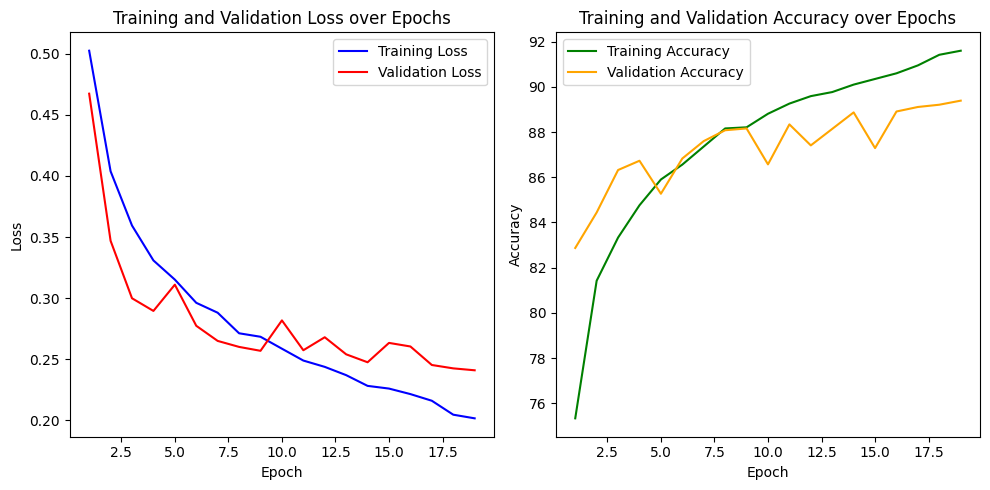

In [ ]:
import matplotlib.pyplot as plt

# loss와 val_loss를 저장할 리스트
losses = [0.50260, 0.40384, 0.35940, 0.33082, 0.31512, 0.29611, 0.28799, 0.27115, 0.26830, 0.25852, 0.24881, 0.24364, 0.23686, 0.22807, 0.22586, 0.22134, 0.21589, 0.20447, 0.20148]
val_losses = [0.46741, 0.34689, 0.29983, 0.28946, 0.31097, 0.27729, 0.26490, 0.25999, 0.25679, 0.28170, 0.25726, 0.26790, 0.25392, 0.24741, 0.26327, 0.26034, 0.24518, 0.24241, 0.24084]

accuracy = [75.33, 81.42, 83.33, 84.76, 85.90, 86.56, 87.36, 88.16, 88.21, 88.81, 89.26, 89.59, 89.77, 90.10, 90.35, 90.60, 90.95, 91.42, 91.60]
val_accuracy = [82.87, 84.44, 86.32, 86.73, 85.27, 86.83, 87.60, 88.08, 88.16, 86.57, 88.34, 87.41, 88.14, 88.87, 87.29, 88.91, 89.11, 89.21, 89.39]

plt.figure(figsize=(10, 5))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses) + 1), losses, color='blue', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracy) + 1), accuracy, color='green', label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

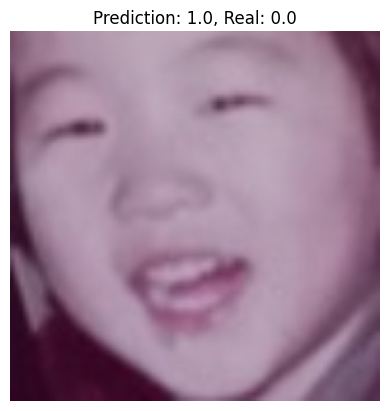

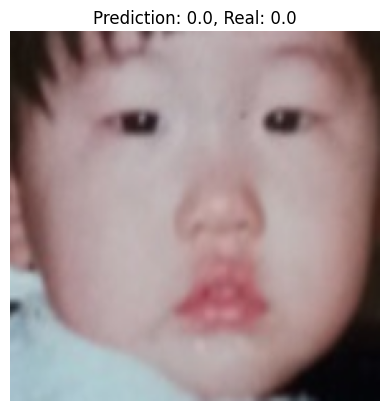

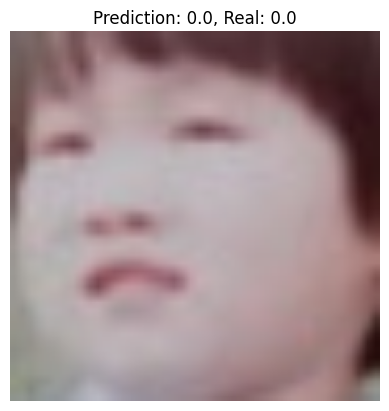

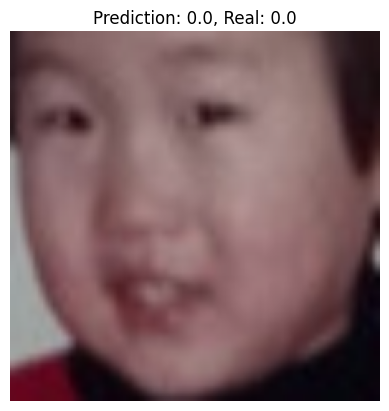

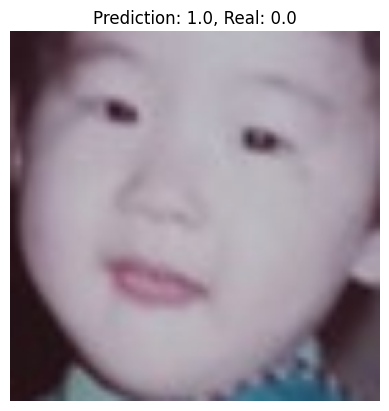

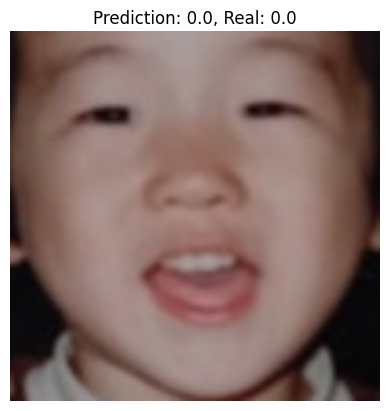

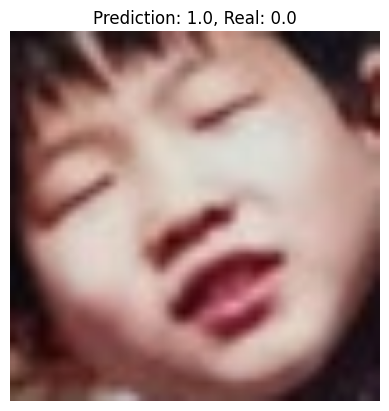

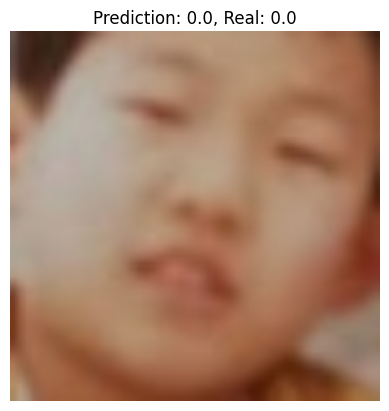

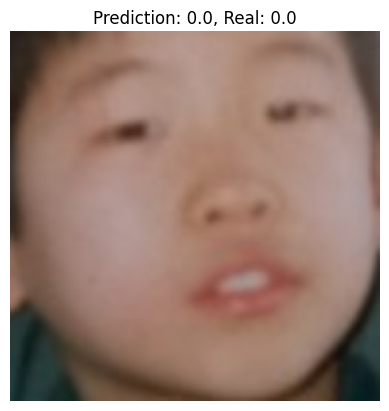

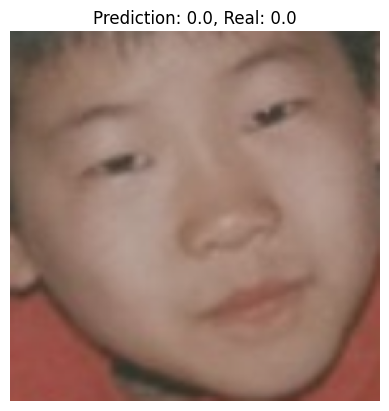

Validation Predictions: [1. 1. 1. ... 1. 1. 1.]
True Labels: [1. 1. 1. ... 1. 1. 1.]
Accuracy : 89.38613861386139


In [ ]:
def test_gender_prediction(dataloader, model, device):
    predictions = []
    true_labels = []
    images = []

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y['gender'].float().to(device)
            pred = model(x)
            pred = torch.sigmoid(pred)
            pred[pred >= 0.5] = 1
            pred[pred < 0.5] = 0

            total += y.size(0)
            correct += torch.sum(pred == y).item()

            predictions.append(pred.cpu().numpy())
            true_labels.append(y.cpu().numpy())
            images.append(x.cpu().numpy())

    accuracy = 100 * correct / total
    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    images = np.concatenate(images, axis=0)
    return predictions, true_labels, images, accuracy

gender_model, opt_gender, start_epoch = load_model(gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v3_checkpoint_epoch_19.pth')
gender_model.to(device)
# validation 데이터로 성별 예측 수행
val_predictions, val_true_labels, val_images, val_accuracy = test_gender_prediction(val_loader, gender_model, device)

# 결과 출력

for i in range(2400,2410):
  image = val_images[i].transpose((1, 2, 0))  # 채널 순서 변경
  mean = np.array([0.6284, 0.4901, 0.4325])
  std = np.array([0.1869, 0.1712, 0.1561])
  image = std * image + mean
  image = np.clip(image, 0, 1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(f'Prediction: {val_predictions[i]}, Real: {val_true_labels[i]}')
  plt.show()

print("Validation Predictions:", val_predictions)
print("True Labels:", val_true_labels)
print("Accuracy :", val_accuracy)

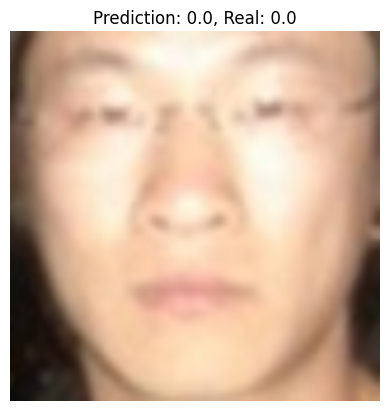

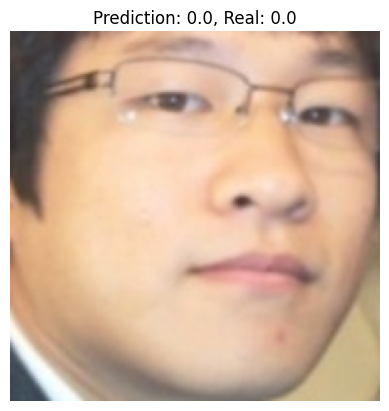

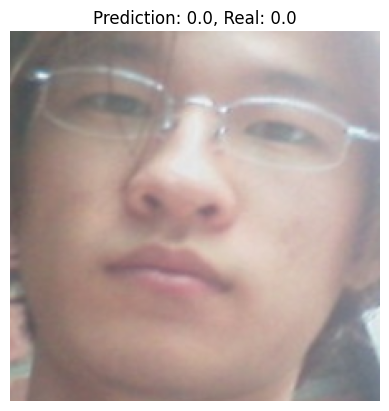

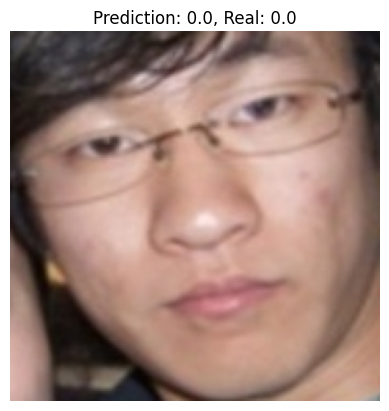

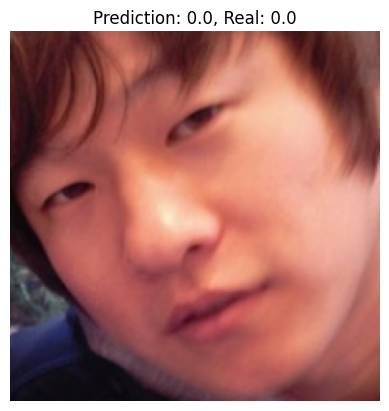

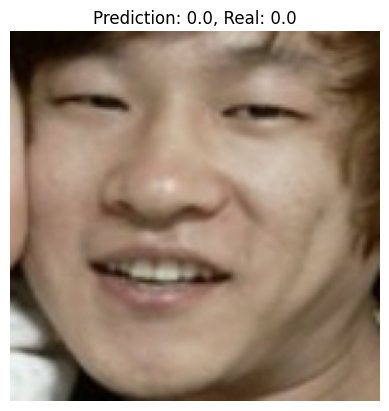

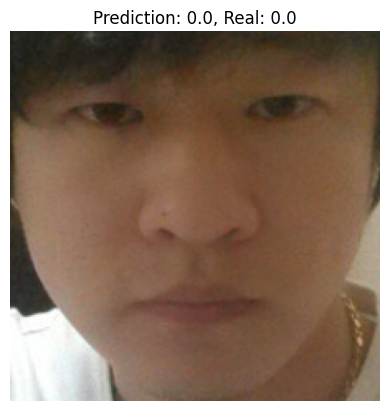

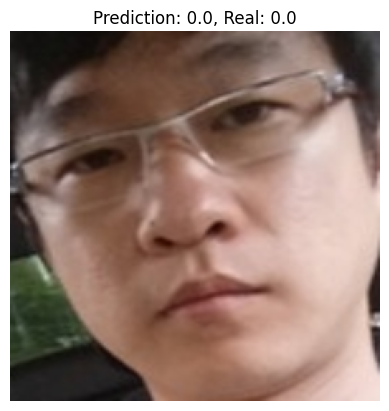

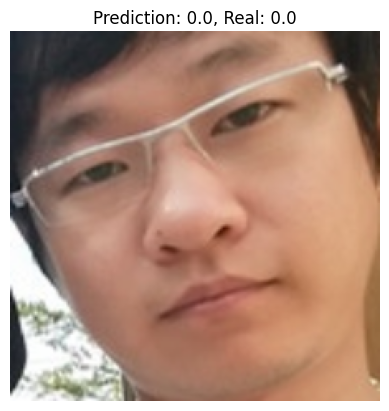

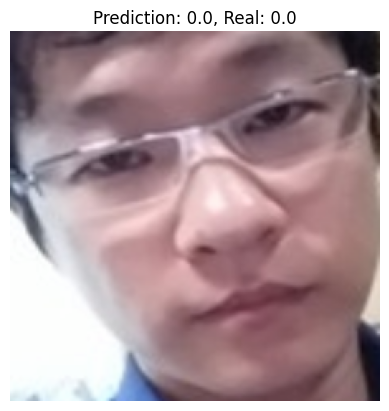

Validation Predictions: [1. 1. 1. ... 1. 1. 1.]
True Labels: [1. 1. 1. ... 1. 1. 1.]
Accuracy : 89.38613861386139


In [ ]:
for i in range(2420,2430):
  image = val_images[i].transpose((1, 2, 0))  # 채널 순서 변경
  mean = np.array([0.6284, 0.4901, 0.4325])
  std = np.array([0.1869, 0.1712, 0.1561])
  image = std * image + mean
  image = np.clip(image, 0, 1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(f'Prediction: {val_predictions[i]}, Real: {val_true_labels[i]}')
  plt.show()

print("Validation Predictions:", val_predictions)
print("True Labels:", val_true_labels)
print("Accuracy :", val_accuracy)

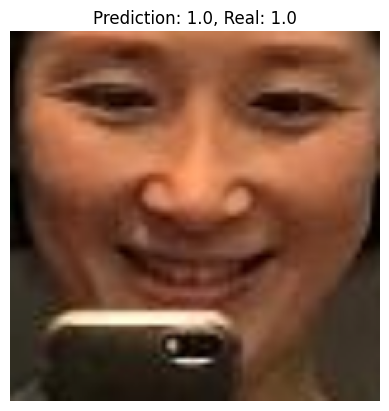

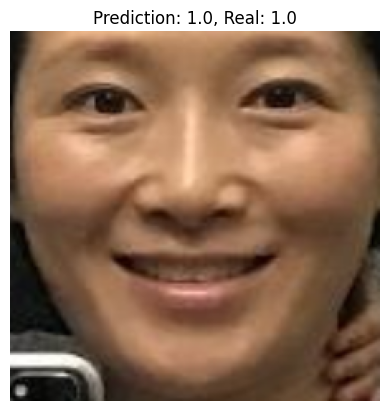

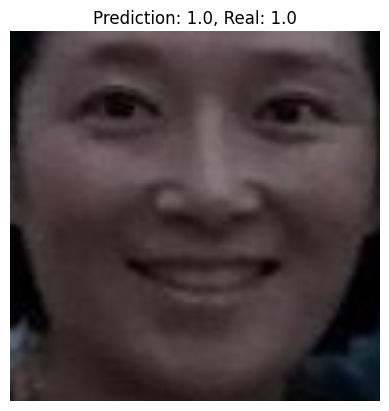

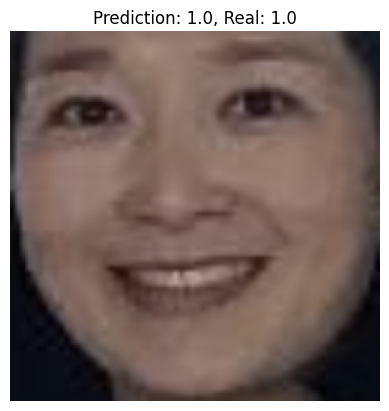

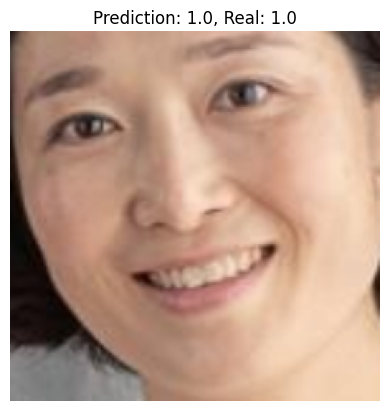

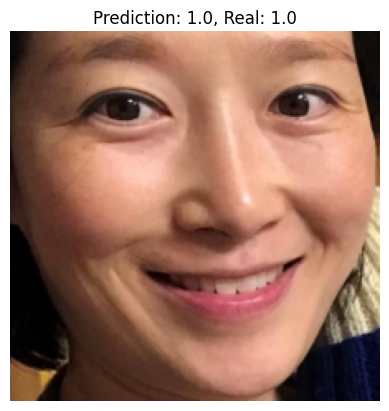

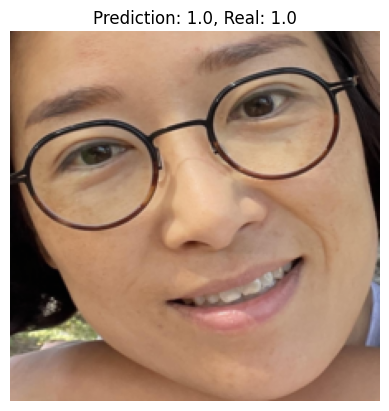

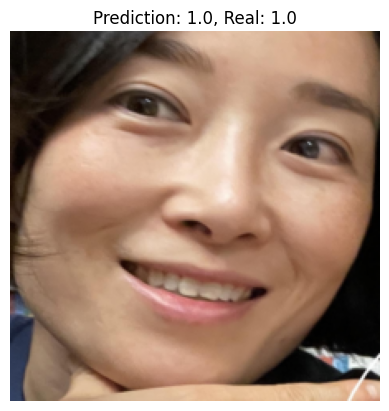

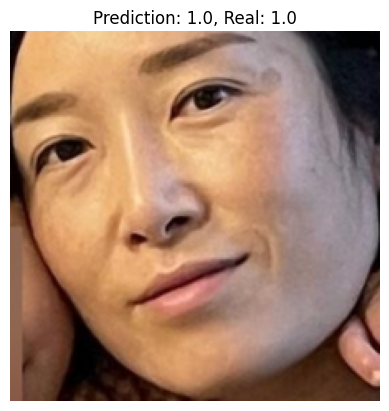

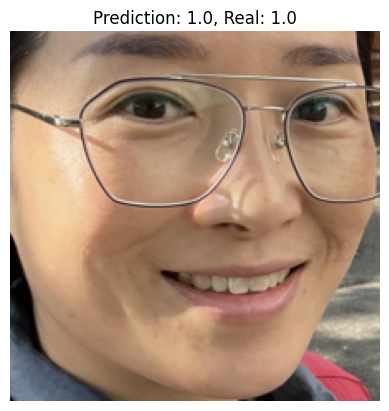

In [ ]:
for i in range(40,50):
  image = val_images[i].transpose((1, 2, 0))  # 채널 순서 변경
  mean = np.array([0.6284, 0.4901, 0.4325])
  std = np.array([0.1869, 0.1712, 0.1561])
  image = std * image + mean
  image = np.clip(image, 0, 1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(f'Prediction: {val_predictions[i]}, Real: {val_true_labels[i]}')
  plt.show()

In [ ]:
# def test_gender_prediction(dataloader, model, device):

#     predictions = []
#     true_labels = []

#     model.eval()
#     with torch.no_grad():
#         for x, y in dataloader:
#             x, y = x.to(device), y['gender'].float().to(device)
#             pred = model(x)
#             pred = torch.sigmoid(pred)
#             predictions.append(pred.numpy())
#             true_labels.append(y.numpy())

#     predictions = np.concatenate(predictions)
#     true_labels = np.concatenate(true_labels)
#     return predictions, true_labels

# gender_model, opt_gender, start_epoch = load_model(gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v3_checkpoint_epoch_19.pth')
# gender_model.to(device)
# # validation 데이터로 성별 예측 수행
# val_predictions, val_true_labels = test_gender_prediction(val_loader, gender_model, device)

# # 결과 출력
# print("Validation Predictions:", val_predictions)
# print("True Labels:", val_true_labels)

Validation Predictions: [0.4870328  0.73781765 0.9197222  ... 0.9995266  0.9970714  0.99393374]
True Labels: [1. 1. 1. ... 1. 1. 1.]


In [ ]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 34.8 MB/s eta 0:00:00


1/1 [==============================] - 0s 152ms/step


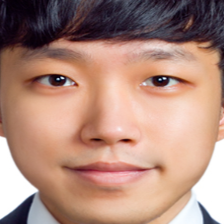

In [ ]:
from mtcnn import MTCNN
import cv2
from google.colab.patches import cv2_imshow

def face_detection(image_path):
  # 이미지 변환
  img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  # MTCNN 클래스 생성
  detector = MTCNN()
  # 얼굴 감지
  detections = detector.detect_faces(img)
  detections

  img_with_dets = img.copy()
  min_conf = 0.9
  for det in detections:
      if det['confidence'] >= min_conf:
          x, y, width, height = det['box']
          # 얼굴 영역 잘라내기
          face_img = img[y:y+height, x:x+width]
          resized_face_img = cv2.resize(face_img, (224, 224))
          resized_face_img = cv2.cvtColor(resized_face_img, cv2.COLOR_RGB2BGR)

  return resized_face_img

image_path = '/content/drive/MyDrive/data/TS_0001/0001_1992_29_00000074_D.png'
face_img = face_detection(image_path)

cv2_imshow(face_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
def gender_predict(image, gender_model):
  # 검출된 얼굴 불러오기
  image =  cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
  image
  image = Image.fromarray(image)

  # 전처리
  preprocess = transforms.Compose([
      transforms.Resize((224, 224)),  # 이미지를 모델에 맞는 크기로 리사이징
      transforms.ToTensor(),           # 이미지를 텐서로 변환
      transforms.Normalize((0.6284, 0.4901, 0.4325), (0.1869, 0.1712, 0.1561)),  # 이미지를 정규화
  ])

  # 이미지 전처리 및 배치 차원 추가
  input_tensor = preprocess(image)
  print(input_tensor.shape)
  input_batch = input_tensor.unsqueeze(0)  # 배치 차원 추가
  print(input_batch.shape)

  # 이미지를 디바이스로 이동
  input_batch = input_batch.to(device)

  # 모델 예측
  with torch.no_grad():
      output = gender_model(input_batch)

  # 예측 결과 해석
  print(torch.sigmoid(output))
  predicted_class = torch.sigmoid(output).item() # 모델의 출력을 확률로 변환
  gender = 'Male' if predicted_class < 0.5 else 'Female'  # 임계값을 기준으로 성별 분류
  print(f'Predicted Gender: {gender} (Probability: {predicted_class:.10f})')

gender_model, opt_gender, start_epoch = load_model(gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v3_checkpoint_epoch_19.pth')
gender_model.to(device)

gender_predict(face_img, gender_model)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor(1.8337e-07, device='cuda:0')
Predicted Gender: Male (Probability: 0.0000001834)


In [ ]:
!pip install retina-face

Facial area: [0, 240, 329, 684]
0 240 329 684


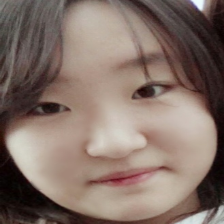

In [ ]:
from retinaface import RetinaFace
import cv2

# 이미지 경로
image_path = '/content/cache/val/VS_0925/0925_2003_15_00000020_F.png'

# 이미지 불러오기
image = cv2.imread(image_path)
resp = RetinaFace.detect_faces(image)
resp

detect_image = image.copy()

# 감지된 얼굴에 사각형 그리기
for face in resp:
  facial_area = resp[face]['facial_area']
  print('Facial area:', facial_area)
  x, y, w, h = facial_area[0], facial_area[1],facial_area[2],facial_area[3]
  print(x,y,w,h)
  # cv2.rectangle(detect_image, (x,y), (w,h), (0,0,255), 2)

  cropped = detect_image[y: h, x: w]
  face_img = cv2.resize(cropped, (224, 224))
  # 결과 출력
  cv2_imshow(face_img)

In [ ]:
def gender_predict(image, gender_model):
  # 검출된 얼굴 불러오기
  image =  cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
  image
  image = Image.fromarray(image)

  # 전처리
  preprocess = transforms.Compose([
      transforms.Resize((224, 224)),  # 이미지를 모델에 맞는 크기로 리사이징
      transforms.ToTensor(),           # 이미지를 텐서로 변환
      transforms.Normalize((0.6284, 0.4901, 0.4325), (0.1869, 0.1712, 0.1561)),  # 이미지를 정규화
  ])

  # 이미지 전처리 및 배치 차원 추가
  input_tensor = preprocess(image)
  print(input_tensor.shape)
  input_batch = input_tensor.unsqueeze(0)  # 배치 차원 추가
  print(input_batch.shape)

  # 이미지를 디바이스로 이동
  input_batch = input_batch.to(device)

  # 모델 예측
  with torch.no_grad():
      output = gender_model(input_batch)

  # 예측 결과 해석
  print(torch.sigmoid(output))
  predicted_class = torch.sigmoid(output).item() # 모델의 출력을 확률로 변환
  gender = 'Male' if predicted_class < 0.5 else 'Female'  # 임계값을 기준으로 성별 분류
  print(f'Predicted Gender: {gender} (Probability: {predicted_class:.10f})')

gender_model, opt_gender, start_epoch = load_model(gender_model, opt_gender, '/content/drive/MyDrive/models/gender_model_v3_checkpoint_epoch_19.pth')
gender_model.to(device)

gender_predict(face_img, gender_model)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor(0.9996, device='cuda:0')
Predicted Gender: Female (Probability: 0.9996478558)
